# Coarse-grain MWE (2-channel)

This notebook shows how coarse-graining works for multivariate Wishart
statistics. We start from a 2-channel time series, build per-frequency Wishart
matrices `Y(f_k)`, then coarse-grain them into `Y_bar` and compare two ways to
factorize `Y_bar` into `U`.

Key idea: the likelihood only depends on `Y_bar`. Any factorization
`Y_bar = U U^H` is valid; the code chooses the compact eigen-based `U`.

**Math summary (per frequency)**

\[
Y(f_k) = \sum_{b=1}^{N_b} X_b(f_k)\, X_b(f_k)^\ast
\]

\[
Y(f_k)=\sum_{\nu=1}^p \lambda^{(k)}_\nu v^{(k)}_\nu v^{(k)\ast}_\nu
      = \sum_{\nu=1}^p u^{(k)}_\nu u^{(k)\ast}_\nu,\quad
u^{(k)}_\nu = \sqrt{\lambda^{(k)}_\nu}\, v^{(k)}_\nu
\]

Text(0.5, 0, 'Time (s)')

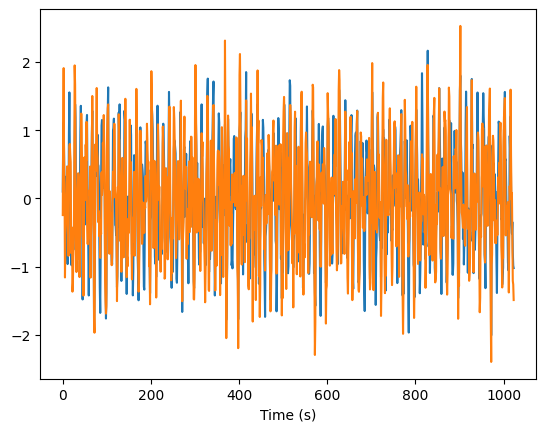

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# --- 2-channel time series ---
fs = 1.0
n = 1024
p = 2

t = np.arange(n) / fs
x1 = (
    0.9 * np.sin(2 * np.pi * 0.08 * t)
    + 0.5 * np.sin(2 * np.pi * 0.15 * t + 0.2)
    + 0.3 * rng.standard_normal(n)
)

x2 = (
    0.8 * x1
    + 0.6 * np.sin(2 * np.pi * 0.12 * t + 0.5)
    + 0.3 * rng.standard_normal(n)
)

x = np.column_stack([x1, x2])

x.shape


plt.plot(t, x)
plt.xlabel("Time (s)")

## Compute block FFTs and Wishart matrices

We split the time series into `Nb` non-overlapping blocks and compute an FFT
per block. The per-frequency Wishart matrix is

`Y(f_k) = sum_b X_b(f_k) X_b(f_k)^H`.

Assuming block FFTs are asymptotically complex normal, we have

\[
Y(f_k) \sim \mathcal{CW}(S(f_k), N_b).
\]

(We skip windowing/scaling here to keep the example minimal.)

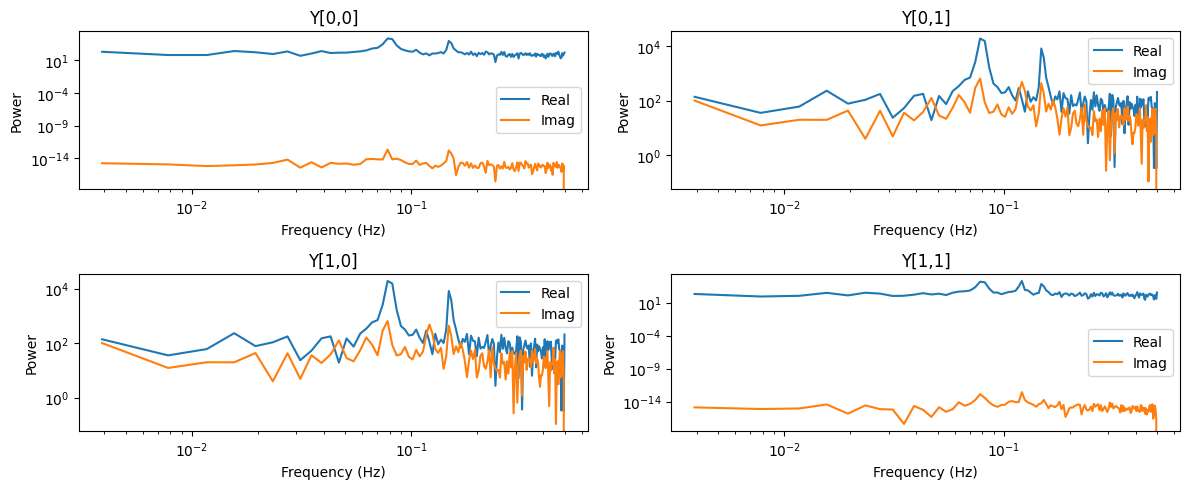

In [5]:
Nb = 4
Lb = n // Nb

blocks = x.reshape(Nb, Lb, p)
blocks = blocks - blocks.mean(axis=1, keepdims=True)

fft_blocks = np.fft.rfft(blocks, axis=1)

freq = np.fft.rfftfreq(Lb, 1 / fs)
# drop zero frequency for stability, matching the library
fft_blocks = fft_blocks[:, 1:, :]
freq = freq[1:]

# Y(f): shape (Nf, p, p)
Y = np.einsum("bnc,bnd->ncd", fft_blocks, np.conj(fft_blocks))

Y.shape

fig, ax = plt.subplots(2,2, figsize=(12, 5))
for i in range(p):
    for j in range(p):
        ax[i,j].loglog(freq, np.abs(Y[:, i, j].real), label="Real")
        ax[i,j].loglog(freq, np.abs(Y[:, i, j].imag), label="Imag")
        ax[i,j].set_title(f"Y[{i},{j}]")
        ax[i,j].set_xlabel("Frequency (Hz)")
        ax[i,j].set_ylabel("Power")
        ax[i,j].legend()
plt.tight_layout()

## Factorize each `Y(f_k)` into `U(f_k)` via eigen-decomposition

\[
Y(f_k)=\sum_{\nu=1}^p \lambda^{(k)}_\nu v^{(k)}_\nu v^{(k)\ast}_\nu
      = \sum_{\nu=1}^p u^{(k)}_\nu u^{(k)\ast}_\nu,
\quad u^{(k)}_\nu = \sqrt{\lambda^{(k)}_\nu}\, v^{(k)}_\nu
\]

In [7]:
# Eigen-based factorization: U(f_k)

# eigvals: (Nf, p), eigvecs: (Nf, p, p)
eigvals, eigvecs = np.linalg.eigh(Y)

# guard against tiny negative eigenvalues from roundoff

sqrt_eigvals = np.sqrt(np.clip(eigvals, 0.0, None))[:, None, :]
U = eigvecs * sqrt_eigvals  # (Nf, p, p)

# Verify reconstruction
Y_from_U = np.einsum("fkc,flc->fkl", U, np.conj(U))

rel_err = np.max(np.abs(Y - Y_from_U)) / np.max(np.abs(Y))

print(f"Relative reconstruction error: {rel_err:.2e}")


Relative reconstruction error: 4.50e-16


## Coarse-grain into bins and build `Y_bar`

Partition the retained frequencies into consecutive bins
\(\{f_1,\ldots,f_{N_l}\} = \cup_{h=1}^{N_c} J_h\) with \(|J_h|=N_h\), and let
\(\bar f_h\) be the midpoint of each bin. Then

\[
\bar Y_h = \sum_{f\in J_h} Y(f).
\]

If \(S(f)\) varies slowly over each bin, then

\[
\bar Y_h \approx \mathcal{CW}(S(\bar f_h), N_b N_h).
\]

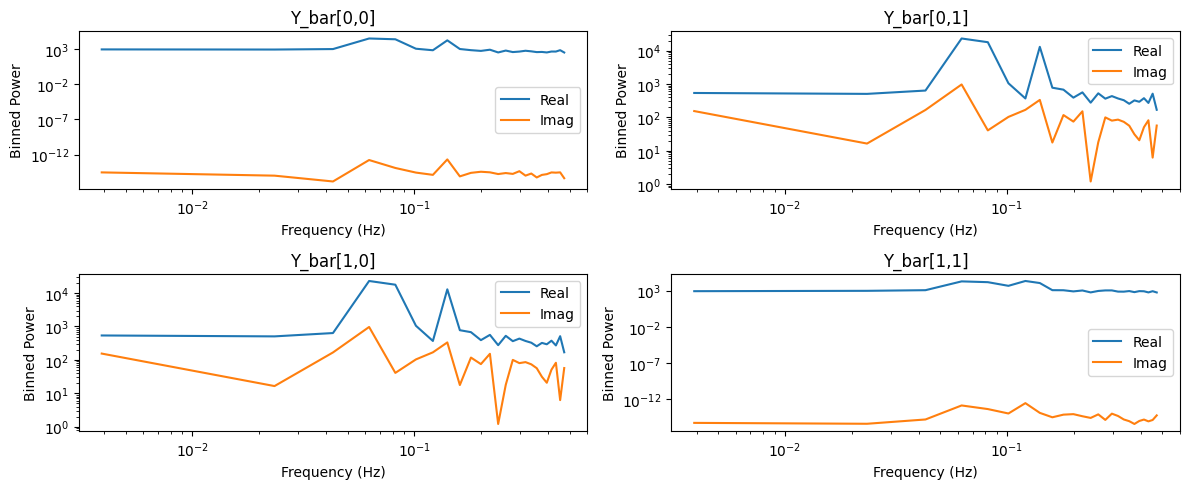

In [8]:
Nh = 5  # frequencies per bin

# trim to an exact multiple of Nh for convenience
Nf = Y.shape[0]
Nl = (Nf // Nh) * Nh
Y = Y[:Nl]
U = U[:Nl]
freq = freq[:Nl]

Nc = Nl // Nh
Y_bar = Y.reshape(Nc, Nh, p, p).sum(axis=1)

Y_bar.shape

# plot the binned periodogram
fig, ax = plt.subplots(2,2, figsize=(12, 5))
for i in range(p):
    for j in range(p):
        ax[i,j].loglog(freq.reshape(Nc, Nh)[:, 0], np.abs(Y_bar[:, i, j].real), label="Real")
        ax[i,j].loglog(freq.reshape(Nc, Nh)[:, 0], np.abs(Y_bar[:, i, j].imag), label="Imag")
        ax[i,j].set_title(f"Y_bar[{i},{j}]")
        ax[i,j].set_xlabel("Frequency (Hz)")
        ax[i,j].set_ylabel("Binned Power")
        ax[i,j].legend()
plt.tight_layout()

## Coarse-grain factorization used in code

After forming
\[\bar Y_h = \sum_{f\in J_h} Y(f),\]
we use the compact eigen-based factorization
\[\bar Y_h = U_h U_h^\ast\]
with \(U_h = V\sqrt{\Lambda}\). This is exactly what the helper
`_coarse_grain_wishart_u` does in
`/Users/avi/Documents/projects/LogPSplinePSD/src/log_psplines/preprocessing/coarse_grain.py`.

In [9]:
# Compact eigen-based factorization of Y_bar
bar_eigvals, bar_eigvecs = np.linalg.eigh(Y_bar)
bar_sqrt = np.sqrt(np.clip(bar_eigvals, 0.0, None))[:, None, :]
U_bar = bar_eigvecs * bar_sqrt  # (Nc, p, p)

Y_bar_from_U = np.einsum("hkc,hlc->hkl", U_bar, np.conj(U_bar))

rel_err = np.max(np.abs(Y_bar - Y_bar_from_U)) / np.max(np.abs(Y_bar))
print(f"Relative reconstruction error (Y_bar): {rel_err:.2e}")

(np.float64(6.808018628189962e-16), np.float64(4.951439772744618e-16))

## Takeaway

Both `U_bar_eig` and the stacked `U_stack` give the same `Y_bar`. The compact
`U_bar_eig` is what your coarse-graining code stores, because it keeps the
shape `(p, p)` and is numerically stable.